<a href="https://colab.research.google.com/github/vincnardelli/covstat/blob/master/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
from scipy.optimize import curve_fit
from scipy.integrate import odeint

# Definizione del modello

In [28]:
# The SIR model differential equations.
def deriv_SIHCDR(y, t, N, beta,gamma,k1,k2,k3,k4,k5):
    S,I,H,C,D,R = y

    dSdt = -(beta*I/N)*S 
    dIdt = (beta*S/N)*I - gamma*I - k1*I
    dHdt = k1*I - (k2+k3)*H
    dCdt = k2*H - (k4+k5)*C
    dDdt = k4*C
    dRdt = k3*H + k5*C + gamma*I 
    
    return dSdt, dIdt, dHdt, dCdt, dDdt, dRdt

def SIHCDR(N,beta,gamma,k1,k2,k3,k4,k5,I0=1,H0=0,C0=0,D0=0,R0=0,t=np.arange(0,365)):
    # Definition of the initial conditions
    # I0 and R0 denotes the number of initial infected people (I0) 
    # and the number of people that recovered and are immunized (R0)
    
    # t ise the timegrid
    
    S0=N-I0-H0-C0-D0-R0  # number of people that can still contract the virus
    
    # Initial conditions vector
    y0 = S0, I0, H0, C0, D0, R0

    # Integrate the SIR equations over the time grid, t.
    ret = odeint(deriv_SIHCDR, y0, t, args=(N,beta,gamma,k1,k2,k3,k4,k5))
    S, I, H, C, D, R = np.transpose(ret)
    
    return (t,S,I,H,C,D,R)

# Dati reali

In [29]:
def moving_avg(array,window=7):
    '''This function computes the moving average, given a time window'''
    array_mobile = []
    for i in range(len(array)-window+1):
        mean_parz = np.mean(array[i:i+window])
        array_mobile.append(mean_parz)
        
    return np.array(array_mobile)

In [30]:
# dati cumulativi
 
data = pd.read_csv('https://github.com/pcm-dpc/COVID-19/raw/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv')
# time threshold
data = data[data['data'] > '2020-10-06']

xdatetime=pd.to_datetime(data['data'])
xdata=np.arange(0,len(data))
ydata=data['totale_casi']
ydata_death=data['deceduti']
ydata_rec=data['dimessi_guariti']
ydata_tamponi=data['tamponi']
ydata_ospedale=np.array(data['totale_ospedalizzati'])
ydata_ricoverati=np.array(data['ricoverati_con_sintomi'])
ydata_terint=np.array(data['terapia_intensiva']) 
ydata_death=np.array(ydata_death)
ydata_deaths = np.diff(ydata_death)
ydata_rec=np.array(ydata_rec)
ydata=np.array(ydata)
 
ydata_inf=np.array(ydata-ydata_rec-ydata_death-ydata_ospedale-ydata_terint)
 
print(data.iloc[-1,:])
 
data.head()

data                            2020-10-19T17:00:00
stato                                           ITA
ricoverati_con_sintomi                         7676
terapia_intensiva                               797
totale_ospedalizzati                           8473
isolamento_domiciliare                       125530
totale_positivi                              134003
variazione_totale_positivi                     7766
nuovi_positivi                                 9338
dimessi_guariti                              252959
deceduti                                      36616
casi_da_sospetto_diagnostico                 310881
casi_da_screening                            112697
totale_casi                                  423578
tamponi                                    13639444
casi_testati                            8.26557e+06
note                                            NaN
Name: 238, dtype: object


,data,stato,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_positivi,variazione_totale_positivi,nuovi_positivi,dimessi_guariti,deceduti,casi_da_sospetto_diagnostico,casi_da_screening,totale_casi,tamponi,casi_testati,note
225,2020-10-06T17:00:00,ITA,3625,319,3944,56190,60134,1231,2677,234099,36030,256986.0,73277.0,330263,11944088,7216379.0,NaN
226,2020-10-07T17:00:00,ITA,3782,337,4119,58457,62576,2442,3678,235303,36061,258884.0,75056.0,333940,12069402,7296766.0,NaN
227,2020-10-08T17:00:00,ITA,3925,358,4283,61669,65952,3376,4458,236363,36083,261304.0,77094.0,338398,12197500,7365751.0,NaN
228,2020-10-09T17:00:00,ITA,4086,387,4473,65637,70110,4158,5372,237549,36111,264137.0,79633.0,343770,12326971,7443593.0,NaN
229,2020-10-10T17:00:00,ITA,4336,390,4726,70103,74829,4719,5724,238525,36140,267320.0,82174.0,349494,12460055,7523702.0,NaN


In [31]:
list_death = [ydata_deaths[0]]*6
ydata_deaths_avg = moving_avg(np.append(list_death,ydata_deaths))

# Confronto tra dati e modello

# automatic optimization

In [32]:
def par_scan(vec):

  beta = vec[0]
  gamma = vec[1]
  k1 = vec[2]
  k2 = vec[3]
  k3 = vec[4]
  k4 = vec[5]
  k5 = vec[6]

  fin_res_SIHCRD=SIHCDR(N=60*10**6,
                   beta=beta,
                   gamma=gamma,
                   k1=k1,
                   k2=k2,
                   k3=k3,
                   k4=k4,
                   k5=k5,
                   I0=ydata_inf[0],D0=ydata_death[0],R0=7*10**6,H0=ydata_ospedale[0],C0=ydata_terint[0])

  time=fin_res_SIHCRD[0]

  # model predictions
  ymodel_inf = fin_res_SIHCRD[2][0:len(ydata_inf)]
  ymodel_ospedale = fin_res_SIHCRD[3][0:len(ydata_inf)]
  ymodel_terint = fin_res_SIHCRD[4][0:len(ydata_inf)]
  ymodel_deaths = np.diff(fin_res_SIHCRD[5][0:len(ydata_inf)])

  # comparison with true data
  delta_inf = round(np.mean(np.abs(ymodel_inf - ydata_inf)/ydata_inf)*100,2)
  delta_ospedale = round(np.mean(np.abs(ymodel_ospedale - ydata_ospedale)/ydata_ospedale)*100,2)
  delta_terint = round(np.mean(np.abs(ymodel_terint - ydata_terint)/ydata_terint)*100,2)
  delta_deaths = round(np.mean(np.abs(ymodel_deaths - ydata_deaths)/ydata_deaths)*100,2)

  delta_avg = round((delta_inf+delta_ospedale+delta_terint+delta_deaths)/4,2)

  print(delta_inf,delta_ospedale,delta_terint,delta_deaths,delta_avg)

  return delta_avg

In [33]:
x0=np.array([0.5,0.3,1/5, 1/10, 1/10, 1/30, 1/20])
#x0=np.array([0.4,0.3,0.1,0.1,0.1,0.1,0.1])
#x0=np.array([0.52557283, 0.38909435, 0.01309729, 0.0252596 , 0.12692909,0.08061447, 0.13958516])

par_scan(x0)

47.5 380.4 2024.87 747.14 799.98


799.98

In [34]:
from scipy.optimize import minimize

In [35]:
res = minimize(par_scan,x0,method='nelder-mead',options={'max_iter':1000,'disp': True,'adaptive':True})
 
print(res.message)
print(res.x)

47.5 380.4 2024.87 747.14 799.98
41.69 424.71 2169.17 800.51 859.02
50.94 353.58 1935.61 713.99 763.53
49.84 383.78 2057.42 761.21 813.06
47.5 373.68 2103.28 778.39 825.71
47.5 373.68 2000.53 737.94 789.91
47.5 380.4 2013.84 784.39 806.53
47.5 380.4 2008.36 740.95 794.3
53.85 332.67 1889.28 708.95 746.19
55.24 321.73 1854.74 697.58 732.32
51.49 360.66 1866.64 701.67 745.12
49.77 343.5 1856.07 701.11 737.61
52.52 337.98 1858.07 659.18 726.94
53.17 332.4 1837.3 642.59 716.36
53.99 325.38 1798.13 665.12 710.66
54.8 318.34 1768.59 654.37 699.02
55.81 309.54 1750.46 648.04 690.96
56.82 300.78 1717.77 636.19 677.89
58.05 297.31 1685.61 624.73 666.42
59.26 288.3 1647.1 610.77 651.36
57.69 294.91 1657.75 615.44 656.45
58.81 272.24 1660.98 602.64 648.67
59.7 261.44 1634.04 589.7 636.22
62.22 267.12 1619.53 576.56 631.36
63.55 258.38 1591.25 561.36 618.64
60.6 265.38 1540.71 540.66 601.84
61.28 258.22 1500.5 520.93 585.23
63.92 240.56 1477.92 557.22 584.9
65.1 230.15 1435.49 546.8 569.38
65.29 2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: OptimizeWarning: Unknown solver options: max_iter
  """Entry point for launching an IPython kernel.


 467.15
70.54 170.97 1171.36 414.0 456.72
71.33 160.98 1122.2 396.43 437.74
73.78 155.23 1162.98 420.43 453.1
73.69 153.45 1135.17 364.58 431.72
74.58 145.94 1101.35 343.93 416.45
74.75 144.29 1076.76 356.95 413.19
75.59 137.88 1039.53 340.39 398.35
75.62 137.68 1009.85 336.67 389.96
76.41 131.56 968.24 320.22 374.11
77.7 121.47 935.99 301.9 359.26
78.62 114.92 892.16 283.37 342.27
78.31 122.57 890.2 294.19 346.32
78.61 106.59 872.14 279.74 334.27
79.28 100.41 835.85 264.81 320.09
78.81 107.99 812.55 235.78 308.78
79.36 103.35 772.86 215.65 292.8
81.41 100.03 781.36 217.14 294.98
81.39 94.6 709.02 219.45 276.12
82.03 90.56 668.81 206.31 261.93
82.21 89.25 663.08 190.86 256.35
82.82 85.62 624.9 175.69 242.26
83.11 83.5 632.67 171.26 242.64
83.19 79.38 617.85 156.82 234.31
83.67 76.52 589.03 142.46 222.92
84.06 75.41 548.99 133.47 210.48
84.56 72.44 514.77 118.78 197.64
84.8 77.11 505.93 110.09 194.48
85.3 75.27 471.89 94.77 181.81
84.61 70.19 461.94 108.97 181.43
84.95 67.28 427.9 97.31

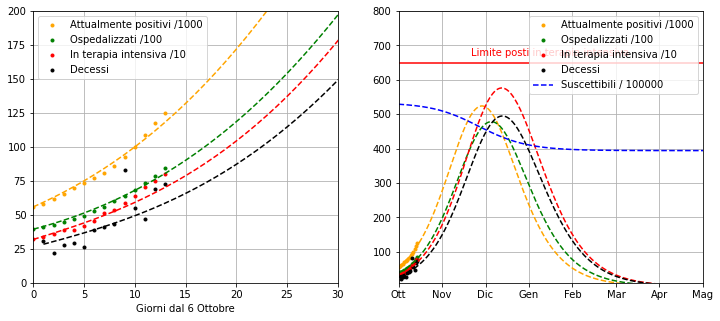

In [36]:
x_opt = res.x
 
fin_res_SIHCRD=SIHCDR(N=60*10**6,
                   beta=x_opt[0],
                   gamma=x_opt[1],
                   k1=x_opt[2],
                   k2=x_opt[3],
                   k3=x_opt[4],
                   k4=x_opt[5],
                   k5=x_opt[6],
                   I0=ydata_inf[0],D0=ydata_death[0],R0=7*10**6,H0=ydata_ospedale[0],C0=ydata_terint[0])
 
time=fin_res_SIHCRD[0]
 
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(xdata,ydata_inf/1000,'.',label='Attualmente positivi /1000',color='orange')
plt.plot(xdata,ydata_ospedale/100,'.',label='Ospedalizzati /100',color='green')
plt.plot(xdata,ydata_terint/10,'.', label='In terapia intensiva /10',color='red')
plt.plot(xdata[1:],ydata_deaths,'.',label='Decessi',color='black')
plt.plot(time,fin_res_SIHCRD[2]/1000,color='orange',linestyle='--')
plt.plot(time,fin_res_SIHCRD[3]/100,color='green',linestyle='--')
plt.plot(time,fin_res_SIHCRD[4]/10,color='red',linestyle='--')
plt.plot(time[1:],np.diff(fin_res_SIHCRD[5]),color='black',linestyle='--')
plt.ylim(0,200)
#plt.xticks(np.arange(0,360,30),['Ott','Nov','Dic','Gen','Feb','Mar','Apr','Mag','Giu','Lug','Ago','Set'])
plt.xlim(0,30)
plt.xlabel('Giorni dal 6 Ottobre')
plt.grid()
plt.legend()
plt.subplot(1,2,2)
plt.plot(xdata,ydata_inf/1000,'.',label='Attualmente positivi /1000',color='orange')
plt.plot(xdata,ydata_ospedale/100,'.',label='Ospedalizzati /100',color='green')
plt.plot(xdata,ydata_terint/10,'.', label='In terapia intensiva /10',color='red')
plt.plot(xdata[1:],ydata_deaths,'.',label='Decessi',color='black')
plt.text(50,670,'Limite posti in terapia intensiva',color='red')
plt.plot(time,fin_res_SIHCRD[4]*0+650,color='red')
plt.plot(time,fin_res_SIHCRD[2]/1000,color='orange',linestyle='--')
plt.plot(time,fin_res_SIHCRD[3]/100,color='green',linestyle='--')
plt.plot(time,fin_res_SIHCRD[4]/10,color='red',linestyle='--')
plt.plot(time[1:],np.diff(fin_res_SIHCRD[5]),color='black',linestyle='--')
plt.plot(time,fin_res_SIHCRD[1]/100000,color='blue',label='Suscettibili / 100000',linestyle='--')
plt.ylim(10,800)
plt.xticks(np.arange(0,360,30),['Ott','Nov','Dic','Gen','Feb','Mar','Apr','Mag','Giu','Lug','Ago','Set'])
plt.xlim(0,210)
plt.grid()
plt.legend()
plt.show()

In [37]:
x_opt

array([0.51928165, 0.38469681, 0.01362065, 0.01637944, 0.12736548,
       0.08587311, 0.04465347])

In [38]:
print('Frazione della popolazione che ha contratto il virus a fine epidemia ',round((60*10**6-fin_res_SIHCRD[1][-1])/(60*10**6)*100),'%')

Frazione della popolazione che ha contratto il virus a fine epidemia  34.0 %


In [39]:
print('Numero di persone contagiate a fine epidemia ',(60*10**6-fin_res_SIHCRD[1][-1])*10**-6,'milioni')

Numero di persone contagiate a fine epidemia  20.57724677059537 milioni


In [40]:
print('Numero decessi seconda ondata ',round(fin_res_SIHCRD[5][1]-ydata_deaths[0]))

Numero decessi seconda ondata  36027.0


In [41]:
# export section for github action
decessi = np.diff(fin_res_SIHCRD[5])
decessi = np.insert(decessi, 0, 28, axis=0)


df = {'time': time, 
      'terapia_intensiva': fin_res_SIHCRD[4], 
      'ospedalizzati/10': fin_res_SIHCRD[3]/10, 
      'attualmente_positivi/100': fin_res_SIHCRD[2]/100, 
      'decessi': decessi, 
      'limite_ti': fin_res_SIHCRD[4]*0+6500}
df = pd.DataFrame(df)
df.drop(df.index[(len(ydata_inf)+30):], inplace=True)
start = datetime.datetime.strptime("6-10-2020", "%d-%m-%Y")


df['date'] = pd.date_range(start, periods=len(ydata_inf)+30)

df.to_csv('modello.csv', index=False)
df

,time,terapia_intensiva,ospedalizzati/10,attualmente_positivi/100,decessi,limite_ti,date
0,0,319.000000,394.400000,558.710000,28.000000,6500.0,2020-10-06
1,1,342.095547,414.678886,592.924279,28.382966,6500.0,2020-10-07
2,2,365.616090,436.708894,629.085981,30.382843,6500.0,2020-10-08
3,3,389.779847,460.508574,667.286899,32.428768,6500.0,2020-10-09
4,4,414.781905,486.105763,707.620660,34.538461,6500.0,2020-10-10
5,5,440.798451,513.536546,750.182389,36.727821,6500.0,2020-10-11
6,6,467.990215,542.844324,795.068324,39.011300,6500.0,2020-10-12
7,7,496.505442,574.078945,842.375352,41.402144,6500.0,2020-10-13
8,8,526.482345,607.295886,892.200477,43.912637,6500.0,2020-10-14
9,9,558.051141,642.555480,944.640209,46.554288,6500.0,2020-10-15
